In [1]:
import tensorflow as tf
from models import decoder, encoder, vae
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

In [24]:
BATCH_SIZE = 256
TRAIN_DATASET_SIZE = 7000
EPOCHS = 100
STEPS_PER_EPOCH = TRAIN_DATASET_SIZE // BATCH_SIZE

IMAGE_SIZE = (256, 256)
LATENT_DIM = 256
RECONSTRUCTION_LOSS_WEIGHT = 100
KL_LOSS_WEIGHT = 1

DATA_FILEPATH = "../data/images"
MODEL_FILEPATH = "../data/models/vae/"
HISTORY_FILEPATH = "../data/others/history_vae_training.csv"

In [3]:
dataset = (
    tf.keras.utils.image_dataset_from_directory(
        directory=DATA_FILEPATH, batch_size=1, image_size=IMAGE_SIZE, shuffle=False
    )
    .unbatch()
    .map(lambda x, y: (x / 255, y))
)

@tf.autograph.experimental.do_not_convert
def select_x(x, _):
    return x

train_dataset = dataset.filter(lambda x, y: y == 1).map(select_x).batch(BATCH_SIZE)
validation_dataset = dataset.filter(lambda x, y: y == 2).map(select_x).batch(BATCH_SIZE)

Found 10000 files belonging to 3 classes.


In [4]:
decoder_model = decoder.build_decoder(LATENT_DIM)
encoder_model = encoder.build_encoder(LATENT_DIM)

vae_model = vae.VAE(encoder_model, decoder_model, RECONSTRUCTION_LOSS_WEIGHT, KL_LOSS_WEIGHT)
vae_model.compile(optimizer=tf.keras.optimizers.legacy.Adam())

In [5]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_reconstruction_loss", patience=5, restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_FILEPATH,
    save_weights_only=True,
    monitor="val_reconstruction_loss",
    mode="min",
    save_best_only=True,
)

csv_logger = tf.keras.callbacks.CSVLogger(HISTORY_FILEPATH, append=True)

In [6]:
steps_per_epoch = TRAIN_DATASET_SIZE // BATCH_SIZE

history = vae_model.fit(
    train_dataset.repeat(STEPS_PER_EPOCH * EPOCHS),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    batch_size=None,
    validation_data=validation_dataset,
    callbacks=[early_stopping, model_checkpoint, csv_logger],
)

Epoch 1/100


2023-05-14 21:02:31.474471: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]
2023-05-14 21:02:31.474692: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_4}}]]


 1/54 [..............................] - ETA: 4:34 - loss: 4542273.5000 - reconstruction_loss: 45422.7305 - kl_loss: 0.3275

KeyboardInterrupt: 

NameError: name 'history' is not defined

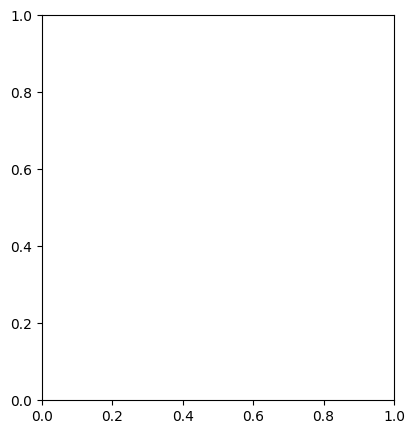

In [61]:
history_vae_training = pd.read_csv(HISTORY_FILEPATH)

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(history_vae_training["reconstruction_loss"])
plt.plot(history_vae_training["val_reconstruction_loss"])
plt.ylabel("reconstruction loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")

plt.subplot(122)
plt.plot(history_vae_training["kl_loss"])
plt.plot(history_vae_training["val_kl_loss"])
plt.ylabel("kl loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")

plt.show()

In [ ]:
_, _, z = encoder_model.predict(validation_dataset)

2023-05-14 21:13:19.923773: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]
2023-05-14 21:13:19.923997: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]


 6/40 [===>..........................] - ETA: 21s

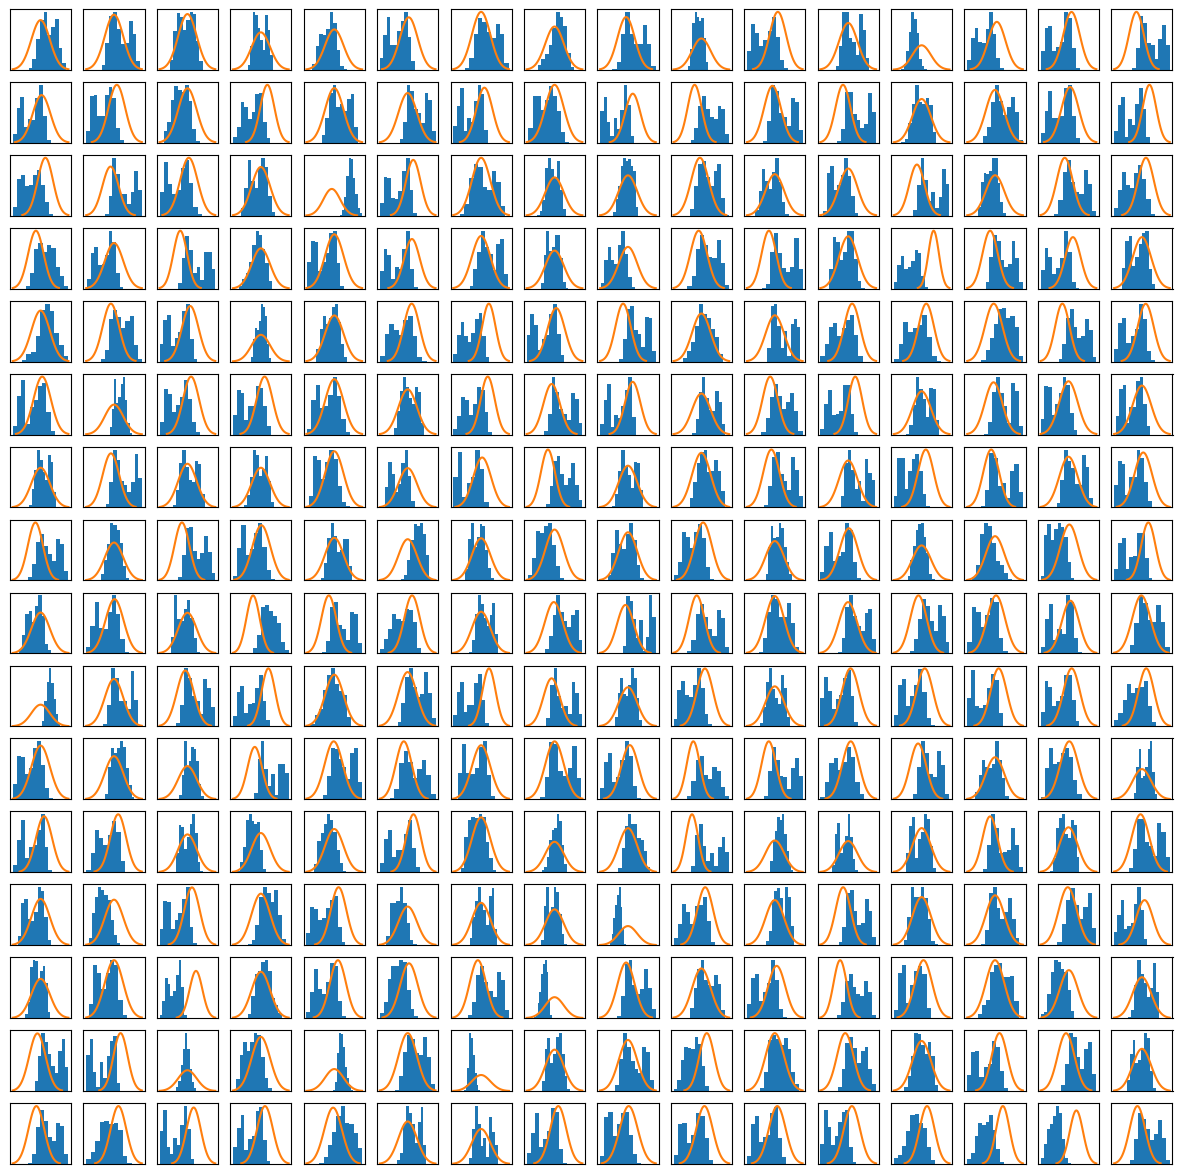

In [34]:
plot_size = int(np.sqrt(LATENT_DIM))

x_vector = np.linspace(-3, 3, 100)
norm_distribution = norm.pdf(x_vector, 0, 1)

plt.figure(figsize=(15, 15))


for i in range(LATENT_DIM):
    plt.subplot(plot_size, plot_size, i + 1)
    plt.hist(z[:, i], density=True)
    plt.plot(x_vector, norm_distribution)
    plt.xticks([])
    plt.yticks([])
plt.show()